# Solução do problema Knapsack

### Uso de três técnicas diferentes
1. Busca exaustiva
2. Greedy
3. Algoritmos Genéticos

In [7]:
# Stephen Marsland, 2008, 2014
# Adaptação e correção de bugs por Hendrik Macedo, 2017

import numpy as np
import pylab as pl
import time

maxSize = 1000    
#sizes = np.array([109.60,125.48,52.16,195.55,58.67,61.87,92.95,93.14,155.05,110.89,13.34,132.49,194.03,121.29,179.33,139.02,198.78,192.57,81.66,128.90])
sizes = 300*np.random.random_sample(20,)
print(sizes)

[ 221.99958675  283.2993247    61.94462507  139.86408967  252.80604844
  245.97933132   75.9323466    10.17976101  278.46006178  197.70584004
  218.38329071   74.2130657    89.45550753   78.83351275  123.73206562
  294.01543765  198.82724467  286.72634331  101.89624908  191.48058634]


### Busca exaustiva

In [8]:
def exhaustive():
    start = time.time()
    best = 0

    twos = np.arange(-len(sizes),0,1)
    twos = 2.0**twos
    for i in range(2**len(sizes)-1):
        string = np.remainder(np.floor(i*twos),2) 
        fitness = np.sum(string*sizes)
        if fitness > best and fitness<maxSize:
            best = fitness
            bestString = string
    finish = time.time()
    print ("Tempo de execução: ",finish-start)
    print ("Maior valor encontrado: ",best)
    print ("Solução correspondente (itens selecionados): ",sizes[bestString>0])
          
exhaustive()

Tempo de execução:  7.962965965270996
Maior valor encontrado:  999.99519846
Solução correspondente (itens selecionados):  [ 283.2993247    61.94462507  197.70584004   74.2130657    89.45550753
  101.89624908  191.48058634]


### Greedy

In [9]:
def greedy():
    start = time.time()
    sizes.sort()
    newSizes = sizes[-1:0:-1]
    space = maxSize
    
    while len(newSizes)>0 and space>newSizes[-1]:
        # Pick largest item that will fit
        item = np.where(space>newSizes)[0][0]
        #print (newSizes[item])
        space = space-newSizes[item]
        newSizes = np.concatenate((newSizes[:item],newSizes[item+1:]))
    finish = time.time()
    print ("Tempo de execução: ",finish-start)
    print ("Maior valor encontrado: = ",maxSize-space)
    
greedy()

Tempo de execução:  0.00010800361633300781
Maior valor encontrado: =  987.773171279


### Algoritmos Genéticos

#### Fitness

In [10]:
def fit(pop):

	fitness = np.sum(sizes*pop,axis=1)
	fitness = np.where(fitness>maxSize,maxSize-2*(fitness-maxSize),fitness)
		
	return fitness

#### Algoritmo

In [12]:
class ga:

	def __init__(self,stringLength,nEpochs,populationSize=100,mutationProb=-1,crossover='un',nElite=4,tournament=True):
		""" Constructor"""
		self.stringLength = stringLength
		
		# Population size should be even
		if np.mod(populationSize,2)==0:
			self.populationSize = populationSize
		else:
			self.populationSize = populationSize+1
		
		if mutationProb < 0:
			 self.mutationProb = 1/stringLength
		else:
			 self.mutationProb = mutationProb
			 	  
		self.nEpochs = nEpochs

		self.fitnessFunction = 'fit'

		self.crossover = crossover
		self.nElite = nElite
		self.tournment = tournament

		self.population = np.random.rand(self.populationSize,self.stringLength)
		self.population = np.where(self.population<0.5,0,1)
		
	def runGA(self,plotfig):
		"""The basic loop"""
		pl.ion()
		#plotfig = pl.figure()
		bestfit = np.zeros(self.nEpochs)

		for i in range(self.nEpochs):
			# Compute fitness of the population
			fitness = eval(self.fitnessFunction)(self.population)

			# Pick parents -- can do in order since they are randomised
			newPopulation = self.fps(self.population,fitness)

			# Apply the genetic operators
			if self.crossover == 'sp':
				newPopulation = self.spCrossover(newPopulation)
			elif self.crossover == 'un':
				newPopulation = self.uniformCrossover(newPopulation)
			newPopulation = self.mutate(newPopulation)

			# Apply elitism and tournaments if using
			if self.nElite>0:
				newPopulation = self.elitism(self.population,newPopulation,fitness)
	
			if self.tournament:
				newPopulation = self.tournament(self.population,newPopulation,fitness,self.fitnessFunction)
	
			self.population = newPopulation
			bestfit[i] = fitness.max()

			if (np.mod(i,1)==0):
				print (i, fitness.max())	
			#pl.plot([i],[fitness.max()],'r+')
		pl.plot(bestfit,'kx-')
		#pl.show()
	
	def fps(self,population,fitness):

		# Scale fitness by total fitness
		fitness = fitness/np.sum(fitness)
		fitness = 10*fitness/fitness.max()
		
		# Put repeated copies of each string in according to fitness
		# Deal with strings with very low fitness
		j=0
		while np.round(fitness[j])<1:
			j = j+1
		
		newPopulation = np.kron(np.ones((int(np.round(fitness[j])),1)),population[j,:])

		# Add multiple copies of strings into the newPopulation
		for i in range(j+1,self.populationSize):
			if np.round(fitness[i])>=1:
				newPopulation = np.concatenate((newPopulation,np.kron(np.ones((int(np.round(fitness[i])),1)),population[i,:])),axis=0)

		# Shuffle the order (note that there are still too many)
		indices = list(range(np.shape(newPopulation)[0]))
		np.random.shuffle(indices)
		newPopulation = newPopulation[indices[:self.populationSize],:]
		return newPopulation	

	def spCrossover(self,population):
		# Single point crossover
		newPopulation = np.zeros(np.shape(population))
		crossoverPoint = np.random.randint(0,self.stringLength,self.populationSize)
		for i in range(0,self.populationSize,2):
			newPopulation[i,:crossoverPoint[i]] = population[i,:crossoverPoint[i]]
			newPopulation[i+1,:crossoverPoint[i]] = population[i+1,:crossoverPoint[i]]
			newPopulation[i,crossoverPoint[i]:] = population[i+1,crossoverPoint[i]:]
			newPopulation[i+1,crossoverPoint[i]:] = population[i,crossoverPoint[i]:]
		return newPopulation

	def uniformCrossover(self,population):
		# Uniform crossover
		newPopulation = np.zeros(np.shape(population))
		which = np.random.rand(self.populationSize,self.stringLength)
		which1 = which>=0.5
		for i in range(0,self.populationSize,2):
			newPopulation[i,:] = population[i,:]*which1[i,:] + population[i+1,:]*(1-which1[i,:])
			newPopulation[i+1,:] = population[i,:]*(1-which1[i,:]) + population[i+1,:]*which1[i,:]
		return newPopulation
		
	def mutate(self,population):
		# Mutation
		whereMutate = np.random.rand(np.shape(population)[0],np.shape(population)[1])
		population[np.where(whereMutate < self.mutationProb)] = 1 - population[np.where(whereMutate < self.mutationProb)]
		return population

	def elitism(self,oldPopulation,population,fitness):
		best = np.argsort(fitness)
		best = np.squeeze(oldPopulation[best[-self.nElite:],:])
		indices = list(range(np.shape(population)[0]))
		np.random.shuffle(indices)
		population = population[indices,:]
		population[0:self.nElite,:] = best
		return population

	def tournament(self,oldPopulation,population,fitness,fitnessFunction):
		newFitness = eval(self.fitnessFunction)(population)
		for i in range(0,np.shape(population)[0],2):
			f = np.concatenate((fitness[i:i+2],newFitness[i:i+2]),axis=0)
			indices = np.argsort(f)
			if indices[-1]<2 and indices[-2]<2:
				population[i,:] = oldPopulation[i,:]
				population[i+1,:] = oldPopulation[i+1,:]
			elif indices[-1]<2:
				if indices[0]>=2:
					population[i+indices[0]-2,:] = oldPopulation[i+indices[-1]]
				else:
					population[i+indices[1]-2,:] = oldPopulation[i+indices[-1]]
			elif indices[-2]<2:
				if indices[0]>=2:
					population[i+indices[0]-2,:] = oldPopulation[i+indices[-2]]
				else:
					population[i+indices[1]-2,:] = oldPopulation[i+indices[-2]]
		return population

#### Execução

Tempo de execução:  0.0003879070281982422
0 986.069768885
1 986.069768885
2 994.406328935
3 998.172509874
4 998.702165815
5 998.702165815
6 998.702165815
7 998.702165815
8 998.702165815
9 998.702165815
10 998.702165815
11 998.702165815
12 998.702165815
13 998.702165815
14 998.702165815
15 998.702165815
16 999.607632774
17 999.607632774
18 999.607632774
19 999.607632774
20 999.607632774
21 999.607632774
22 999.607632774
23 999.607632774
24 999.607632774
25 999.607632774
26 999.607632774
27 999.607632774
28 999.607632774
29 999.607632774
30 999.607632774
31 999.607632774
32 999.777949058
33 999.777949058
34 999.777949058
35 999.777949058
36 999.777949058
37 999.777949058
38 999.777949058
39 999.777949058
40 999.777949058
41 999.777949058
42 999.777949058
43 999.777949058
44 999.777949058
45 999.777949058
46 999.777949058
47 999.777949058
48 999.777949058
49 999.777949058
50 999.777949058
51 999.777949058
52 999.777949058
53 999.777949058
54 999.777949058
55 999.777949058
56 999.777949058

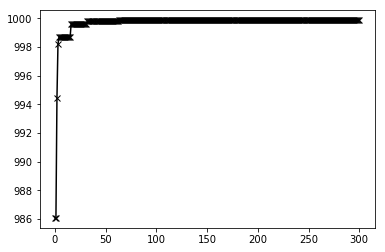

In [13]:
pl.ion()
pl.show()

plotfig = pl.figure()
start = time.time()
ga = ga(20,301,100,-1,'un',4,True)
finish = time.time()
print ("Tempo de execução: ",finish-start)
ga.runGA(plotfig)

pl.pause(0)